In [127]:
import pandas as pd
import numpy as np
import string
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA
import nltk
#import tensorflow_addons as tfa

In [128]:
from nltk.tokenize import word_tokenize

In [129]:
sent = "food is delicious but price is high"
sent_token = word_tokenize(sent)
print(sent)
pca = PCA(n_components=5)
#
glove_vectors = gensim.downloader.load('glove-twitter-25')

food is delicious but price is high


In [130]:
key = [glove_vectors[val].tolist() for val in sent_token]
key = pca.fit_transform(key)

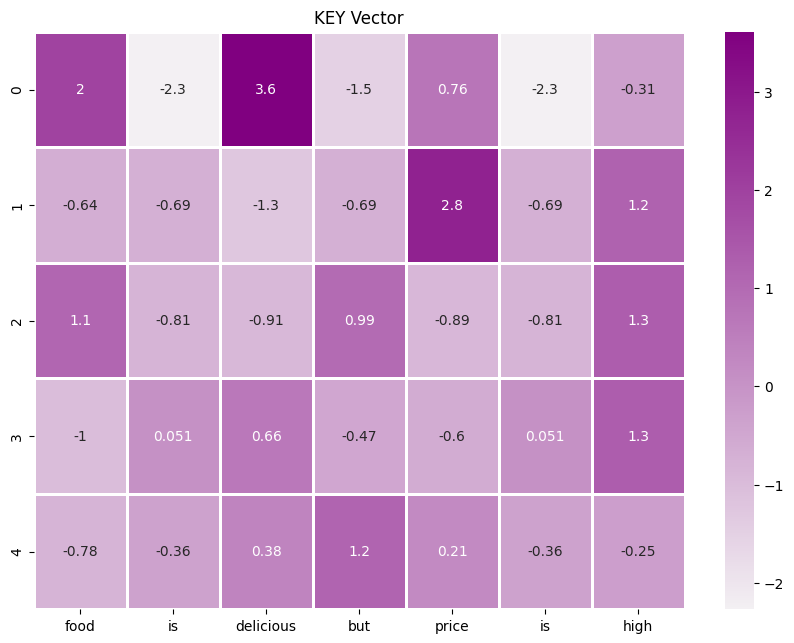

In [131]:
plt.figure(figsize=(10.5, 7.5))
key_df = pd.DataFrame(np.transpose(np.matrix(key)), columns = sent_token)
ax = sns.heatmap(key_df, annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1, ).set_title('KEY Vector')

In [132]:
print("Key Shape", key.shape)

Key Shape (7, 5)


## **2. Get Query**


> $target$ = [tasty, cost]\
$QUERY$ = $representation(target)$

Here, $representation$ is nothing but a word embedding model.

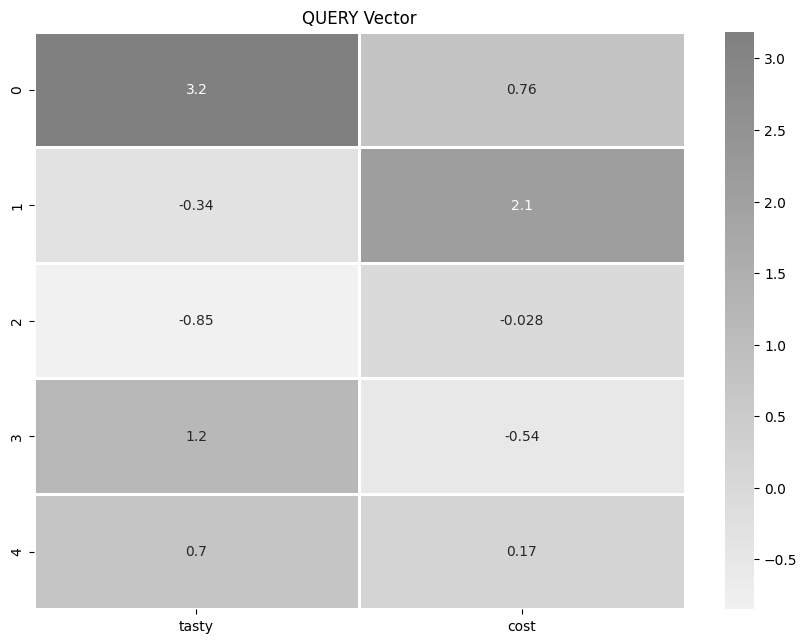

In [133]:
#Query text
target = ['tasty','cost']

#Query embedding and dimensionality reduction
QUERY = [glove_vectors[i].tolist() for i in target]
QUERY = pca.transform(QUERY)


#Plot
plt.figure(figsize=(10.5, 7.5))
query_df = pd.DataFrame(np.transpose(QUERY), columns = target)
ax = sns.heatmap(query_df, annot=True, cmap=sns.light_palette("grey", as_cmap=True), linewidths=1, ).set_title('QUERY Vector', )

In [134]:
print("QUERY Vector", QUERY.shape)

QUERY Vector (2, 5)


## **3. Compute Energy Function.**

> Here, Energy Function is $Dot Product$.

In [135]:
# Key Shape (7, 5)
# QUERY Vector (2, 5) -> transpose > (5,2)
Energy = np.matmul(key,np.transpose(QUERY))
Energy

array([[ 3.78234438,  0.51131411],
       [-6.5123468 , -3.23661494],
       [13.77885647, -0.24969932],
       [-5.12176439, -2.17613397],
       [ 1.67441567,  6.85134696],
       [-6.5123468 , -3.23661494],
       [-1.08915853,  1.53640209]])

In [136]:
def softmax(x):
    x = np.array(x)
    e_x = np.exp(x)
    return e_x/e_x.sum(axis=0)

Atten_weight = softmax(Energy)

In [137]:
Atten_weight

array([[4.55562135e-05, 1.75074732e-03],
       [1.54035224e-09, 4.12589875e-05],
       [9.99948551e-01, 8.17936405e-04],
       [6.18788614e-09, 1.19146037e-04],
       [5.53459457e-06, 9.92349723e-01],
       [1.54035224e-09, 4.12589875e-05],
       [3.49044491e-07, 4.87992924e-03]])

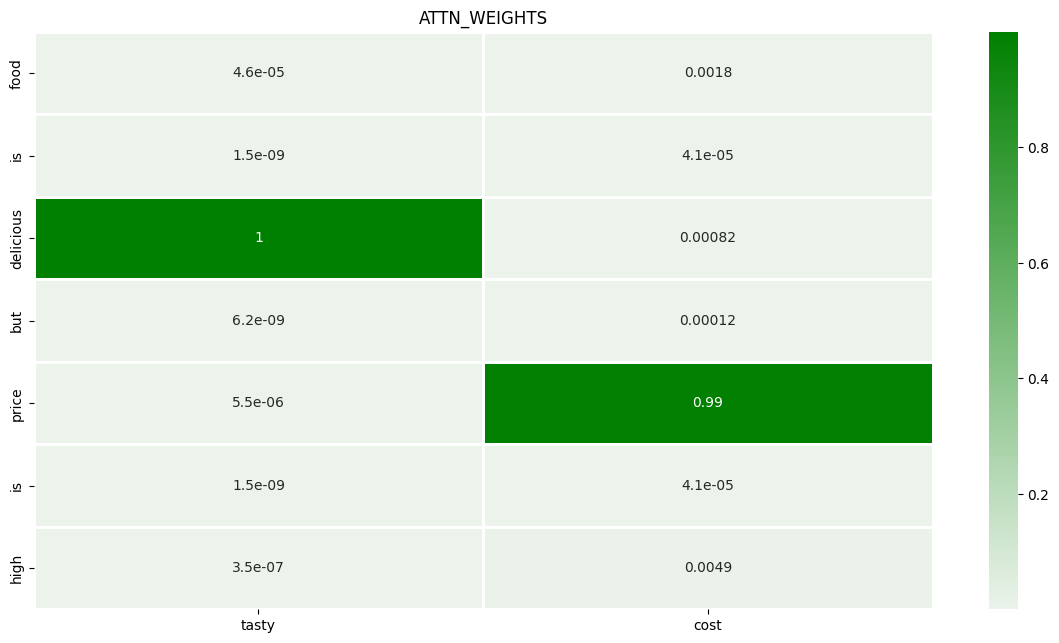

In [138]:
def softmax(x):
    # Compute attention weights
    x = np.array(x, dtype=np.float64)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)

ATTN_WEIGHTS = softmax(Energy)

attn_df = pd.DataFrame(Atten_weight, index = sent_token, columns = target)

plt.figure(figsize=(14.5, 7.5))
ax = sns.heatmap(attn_df , annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1).set_title('ATTN_WEIGHTS', )

In [143]:
VALUE = np.matrix(key)
VALUE

matrix([[ 1.96900318, -0.64309197,  1.10729256, -1.01865012, -0.78032927],
        [-2.27102002, -0.68510808, -0.80786359,  0.05096186, -0.36301194],
        [ 3.61348782, -1.27836926, -0.91090248,  0.66222795,  0.38275554],
        [-1.49475253, -0.69012906,  0.98928402, -0.47255585,  1.16115002],
        [ 0.76057624,  2.7761966 , -0.88824707, -0.59936418,  0.21437308],
        [-2.27102002, -0.68510808, -0.80786359,  0.05096186, -0.36301194],
        [-0.30627467,  1.20560984,  1.31830016,  1.32641849, -0.25192548]])

In [146]:
VALUE.T.shape

(5, 7)

In [148]:
ATTN_WEIGHTS.shape

(7, 2)

In [152]:
Atten_weight

array([[4.55562135e-05, 1.75074732e-03],
       [1.54035224e-09, 4.12589875e-05],
       [9.99948551e-01, 8.17936405e-04],
       [6.18788614e-09, 1.19146037e-04],
       [5.53459457e-06, 9.92349723e-01],
       [1.54035224e-09, 4.12589875e-05],
       [3.49044491e-07, 4.87992924e-03]])

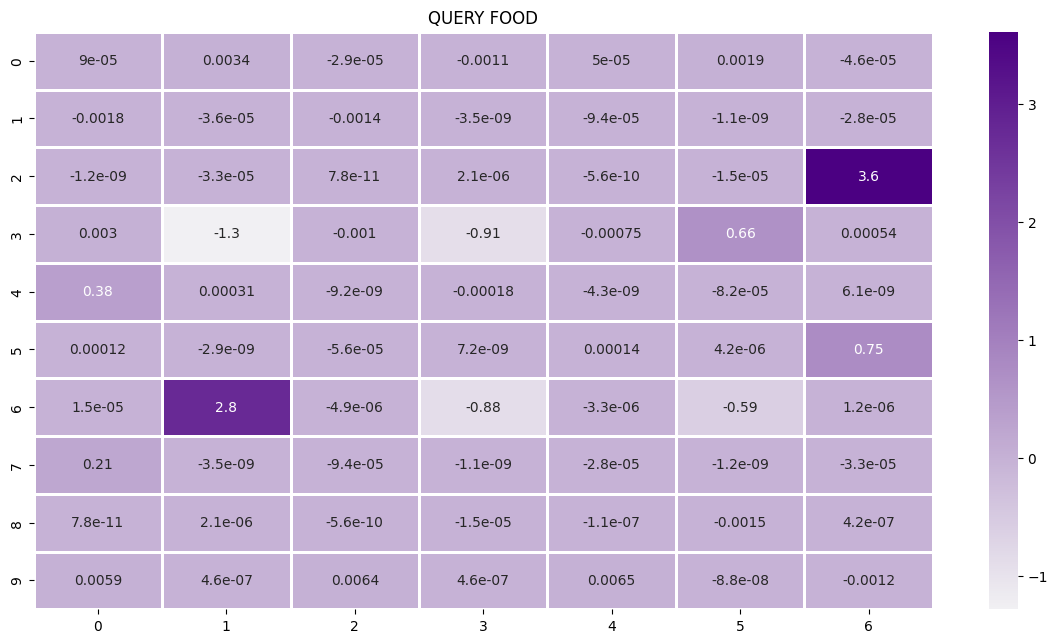

In [158]:
def apply_attention_scores(attention_weights, annotations):
 # Multiple the annotations by their attention weights
 return  [  annotations[:, i] * attention_weights[i] for i in range(len(attention_weights))]


applied_attention_1 = apply_attention_scores(ATTN_WEIGHTS, np.transpose(VALUE))
#applied_attention_1
plt.figure(figsize=(14.5, 7.5))
ax = sns.heatmap(np.array(applied_attention_1).reshape(10, 7), annot=True, cmap=sns.light_palette("indigo", as_cmap=True), linewidths=1).set_title('QUERY FOOD', )

In [165]:
np.array(applied_attention_1).shape

(7, 5, 2)

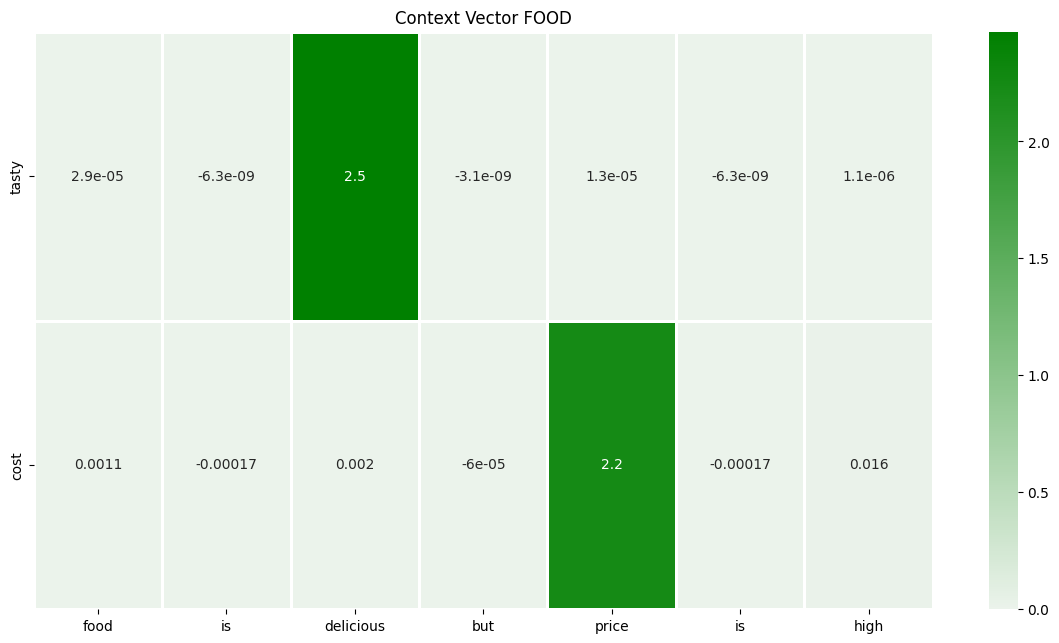

In [174]:
def calculate_attention_vector(applied_attention):
 return np.sum(applied_attention, axis=1)

#applied_attention = np.array([[applied_attention_1]])
attention_vector = calculate_attention_vector(applied_attention_1)
# print(attention_vector.shape)
att_df = pd.DataFrame(attention_vector,columns=target,index=sent_token)
#att_df
plt.figure(figsize=(14.5, 7.5))
ax = sns.heatmap(np.transpose(att_df), annot=True, cmap=sns.light_palette("Green", as_cmap=True), linewidths=1).set_title('Context Vector FOOD', )